In [ ]:
import os
import random
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt


from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Criando a lista de categorias. Para isso vamos ler o conteudo da pasta dataset-foguetes, cada pasta é uma categoria


In [ ]:
root = './dataset_foguetes'
train_split, val_split = 0.7, 0.15
#categories = [pasta for pasta in os.listdir(root) if os.path.isdir(os.path.join(root, pasta))]
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['./dataset_foguetes/proton', './dataset_foguetes/soyuz', './dataset_foguetes/.ipynb_checkpoints']


In [ ]:
Carregar as imagens das pastas que foram localizadas

In [ ]:
# função auxiliar para carregar a imagem e retorná-la e inserir o vetor
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# comtar o número de classes
num_classes = len(categories)

criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [ ]:
random.shuffle(data)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [ ]:
Separate data for labels.

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 1, 1, 0]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [ ]:
# normalizar dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# converter rótulos em vetores one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(5, 3)


In [ ]:
Resumo das informações que temos até o momento

In [ ]:
# Resumo
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 30 images from 3 categories
train / validation / test split: 21, 4, 5
training data shape:  (21, 224, 224, 3)
training labels shape:  (21, 3)


Se tudo funcionou corretamente, você deve ter carregado várias imagens e elas foram divididas em três conjuntos: train, val e test. A forma dos dados de treinamento deve ser (n, 224, 224, 3) onde n é o tamanho do seu conjunto de treinamento e os rótulos devem ser (n, c) onde c é o número de classes (97 no caso de 101_Categorias de objetos.

Observe que dividimos todos os dados em três subconjuntos – um conjunto de treinamento (train), um conjunto de validação (val) e um conjunto de testes (test). A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador utiliza o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajuste ao conjunto de treinamento (overfitting). O conjunto de teste é sempre retirado do algoritmo de treinamento e só é usado no final para avaliar a precisão final do nosso modelo.

Vejamos alguns exemplos de imagens de nosso conjunto de dados.

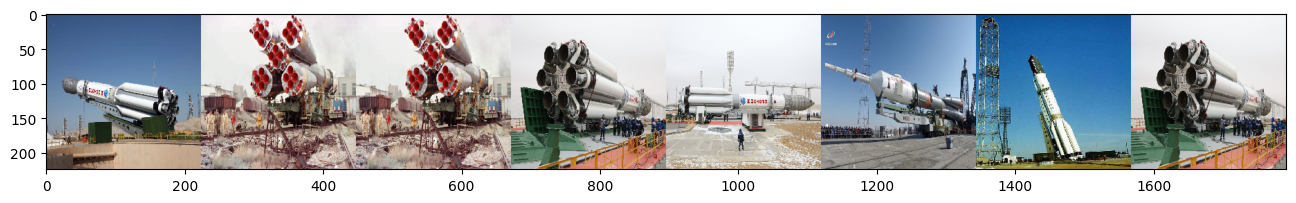

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Transfira o aprendizado começando com uma rede existente

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta é a primeira vez que carrega o VGG16, você precisará esperar um pouco até que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar novamente as camadas com o método summary().

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

VGG16 contém 13 camadas convolucionais e duas camadas totalmente conectadas no final e possui mais de 138 milhões de parâmetros. A maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma taxa de erro entre os 5 primeiros de 8,8%, o que significa que 91,2% das amostras de teste foram classificadas corretamente entre as 5 principais previsões para cada imagem. A precisão máxima - equivalente à métrica de precisão que estamos usando (que a previsão principal está correta) - é de 73%. Isso é especialmente impressionante porque não existem apenas 97, mas 1.000 classes, o que significa que suposições aleatórias nos dariam apenas 0,1% de precisão.

Para usar esta rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e em vez disso a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG desde sua camada de entrada até a penúltima camada e então trabalhar com ela, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe keras Model para inicializar um novo modelo cuja camada de entrada é igual a VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Nota: embora pareça que estamos duplicando esta grande rede, internamente Keras está apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [ ]:
# criando uma referência à camada de entrada do VGG
inp = vgg.input

# criando uma nova camada softmax com neurônios num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# conecte nossa nova camada à penúltima camada em VGG e faça uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# crie uma nova rede entre entrada e saída
model_new = Model(inp, out)

Vamos treinar novamente esta rede, model_new no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos que foram aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador treinável em cada camada como falso (exceto nossa nova camada de classificação), garantimos que todos os pesos e tendências nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se parecer muito com o ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de recursos, temendo que o ajuste fino demais com esse conjunto de dados possa se ajustar demais. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então vamos em frente e congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para uma comparação justa. Em seguida, executamos o resumo novamente para observar a arquitetura da rede.

In [ ]:
# tornar todas as camadas intratáveis ​​congelando pesos (exceto a última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garantir que a última camada seja treinável/não congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.5714 - loss: 1.6028 - val_accuracy: 1.0000 - val_loss: 0.6255
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.4762 - loss: 0.7894 - val_accuracy: 1.0000 - val_loss: 0.2592
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.4286 - loss: 0.9996 - val_accuracy: 1.0000 - val_loss: 0.6196
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4762 - loss: 0.6903 - val_accuracy: 0.0000e+00 - val_loss: 1.5120
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.5714 - loss: 0.7166 - val_accuracy: 0.0000e+00 - val_loss: 1.8936
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.5714 - loss: 0.8123 - val_accuracy: 0.0000e+00 - val_loss: 1.5223
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5714 - loss: 0.6975 - val_accuracy: 0.0000e+00 - val_loss: 0.8731
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.8095 - loss: 0.5883 - val_accuracy: 1.0000 - v

Nossa precisão de validação oscila perto de 80% no final, o que representa uma melhoria de mais de 30% na rede original treinada do zero (o que significa que fazemos previsões erradas em 20% das amostras, em vez de 50%). O congelamento dos pesos elimina a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos representar graficamente a perda e a precisão da validação

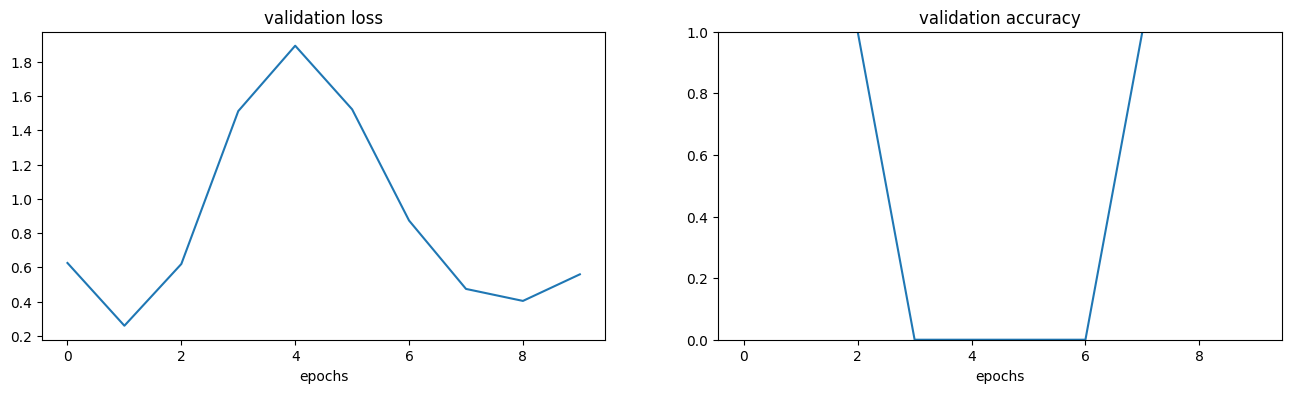

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
Validação final

Again, we do a final validation on the test set.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6120923757553101
Test accuracy: 0.6000000238418579


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [ ]:
img, x = get_image('./teste1.jpg')
probabilities = model_new.predict([x])
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
[[9.2151082e-01 7.8485064e-02 4.0926216e-06]]


In [ ]:
import numpy as np

# Encontrando o índice da maior probabilidade
classe_predita = np.argmax(probabilities)

print(f"A classe predita é: {classe_predita}")

A classe predita é: 0


In [ ]:
print(num_classes)
print(categories)
# Nomes das classes (substitua pelos nomes reais das suas classes)
class_names = ['Classe 1', 'Classe 2', 'Classe 3']

# Iterando sobre as probabilidades e exibindo o nome da classe e sua probabilidade
for prob, class_name in zip(probabilities[0], class_names):
    print(f"{class_name}: {prob * 100:.2f}%")

3
['./dataset_foguetes/proton', './dataset_foguetes/soyuz', './dataset_foguetes/.ipynb_checkpoints']
Classe 1: 92.15%
Classe 2: 7.85%
Classe 3: 0.00%


In [ ]:
img, x = get_image('./teste2.jpg')
probabilities2 = model_new.predict([x])
print(probabilities2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[9.9949646e-01 4.9051800e-04 1.2942310e-05]]


In [ ]:
img, x = get_image('./teste3.jpg')
probabilities3 = model_new.predict([x])
print(probabilities3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
[[1.6049278e-01 8.3932024e-01 1.8701128e-04]]
